# Development Notebook for the JSON parser

In [1]:
# !pip uninstall -y afc
# !pip install ..

### externalConfig.py

### Test it

In [2]:
from afc.externalConfig import read_json_config, DEFAULT_JSON_PATH

In [3]:
import os
import pandas as pd
import datetime as dtm
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 72

try:
    root = os.path.dirname(os.path.abspath(__file__))
except:
    root = os.getcwd()

from afc.utility.weather import read_tmy3
from afc.ctrlWrapper import Controller, make_inputs
from afc.utility.plotting import plot_standard1

Log-message:
 Duration [s]		0.2
Objective [$]		22.24			9.09 (Total Cost)
Cost [$]		13.77 (Energy)	8.47 (Demand)
CO2 Emissions [kg]		0.0

Duration:
 {'duration': {'radiance': 4.129141330718994, 'glare': 66.90952682495117, 'varts': 0.1390981674194336, 'optall': 0.4878365993499756, 'outputs': 0.005560159683227539, 'all': 71.6854178905487}}
Optimization:
 {'opt-stats': {'duration': 0.1968214511871338, 'termination': 'optimal', 'objective': 22.24276582}}


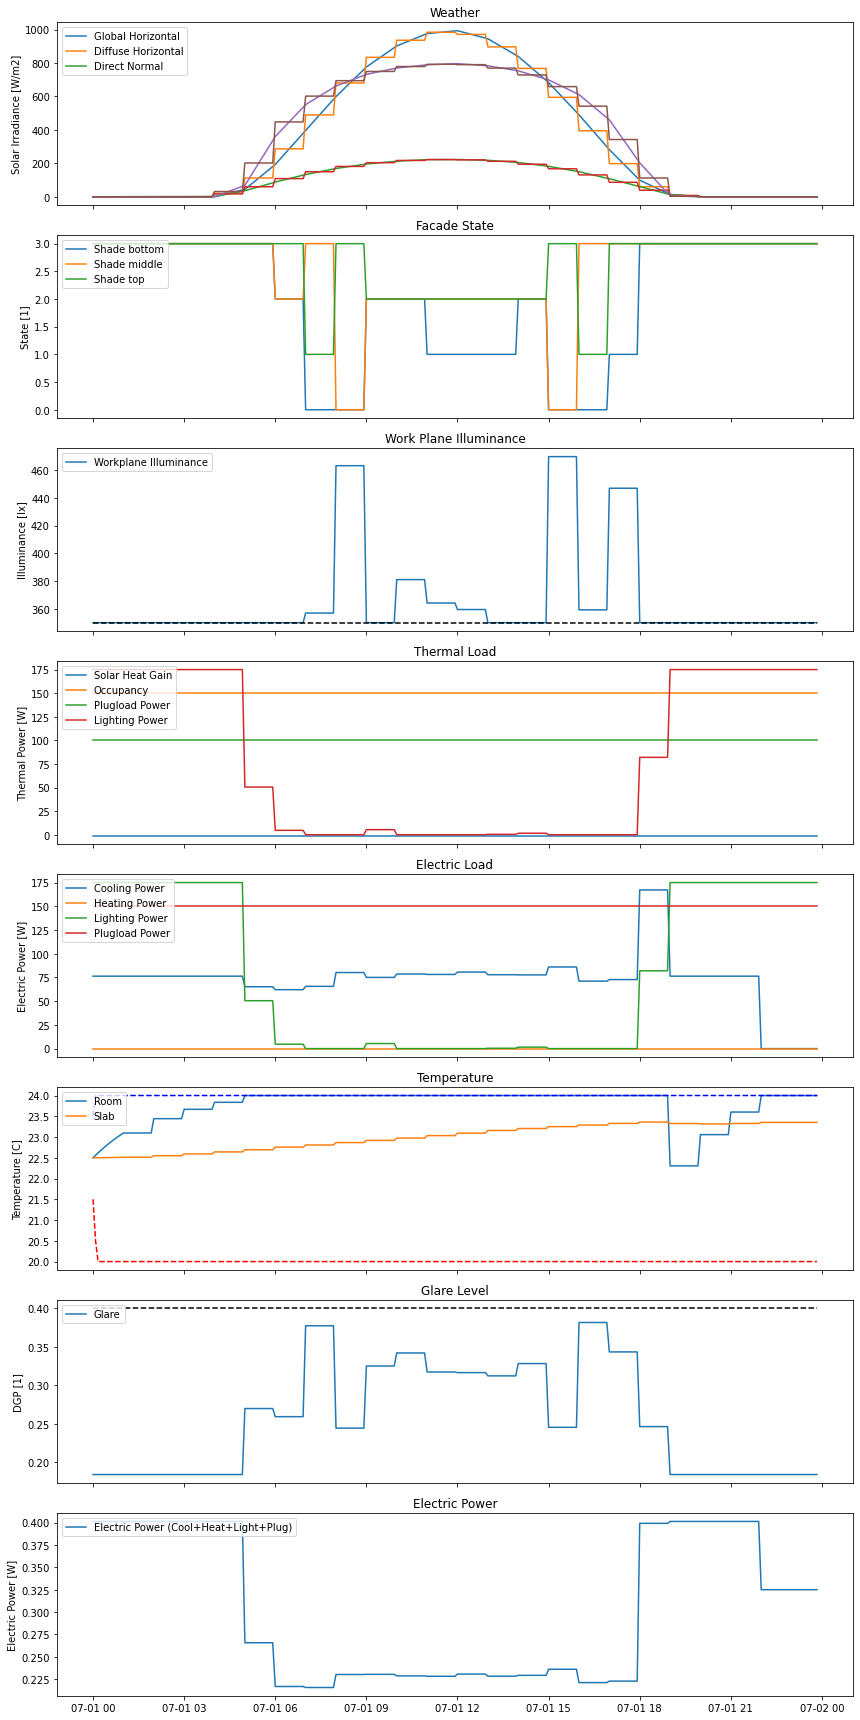

In [4]:
# Import and read weather (forecast) data
weather_path = os.path.join(os.path.dirname(root), 'dev', 'resources', 'weather',
    'USA_CA_San.Francisco.Intl.AP.724940_TMY3.csv')
weather, info = read_tmy3(weather_path, coerce_year=2023)
weather = weather.resample('5min').interpolate()
st = dtm.datetime(2023, 7, 1)
wf = weather.loc[st:st+pd.DateOffset(hours=24),]
wf = wf[['temp_air','dni','dhi','wind_speed']+['ghi']].copy()
wf = wf[wf.index.date == wf.index[0].date()]

# Initialize controller
ctrl = Controller()

# Path to json configuration
json_config_path = DEFAULT_JSON_PATH

# Create the inputs vector
parameter = read_json_config(json_config_path)
inputs = make_inputs(parameter, wf)

# Query controller
ctrl.do_step(inputs=inputs) # Initialize
print('Log-message:\n', ctrl.do_step(inputs=inputs))
print('Duration:\n', ctrl.get_output(keys=['duration']))
print('Optimization:\n', ctrl.get_output(keys=['opt-stats']))
df = pd.DataFrame(ctrl.get_output(keys=['output-data'])['output-data'])
df.index = pd.to_datetime(pd.to_numeric(df.index), unit='ms')


# Remove slab constraints for plotting
df['Temperature 1 Min [C]'] = None
df['Temperature 1 Max [C]'] = None
plot_standard1(pd.concat([wf, df], axis=1).ffill().iloc[:-1])